# PyTorch Model Testing

Test the original unified-detection-v7.pt PyTorch model with the same test image to compare against ONNX results.

**Test Image**: Yellow security seal with QR code (should be classified as `code_seal`)

**Goal**: Determine if the multi-class detection issue exists in the original PyTorch model or was introduced during ONNX conversion.

In [18]:
import torch
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import torchvision.transforms as transforms

# Check PyTorch and device info
print(f"PyTorch version: {torch.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# Class names from the training config
class_names = [
    'code_container_h',
    'code_container_v', 
    'code_license_plate',
    'code_qr_barcode',
    'code_seal'
]

print(f"\nClass mapping:")
for i, name in enumerate(class_names):
    print(f"  {i}: {name}")

PyTorch version: 2.3.0
CUDA available: False
Using device: cpu

Class mapping:
  0: code_container_h
  1: code_container_v
  2: code_license_plate
  3: code_qr_barcode
  4: code_seal


Original image shape: (640, 640, 3)


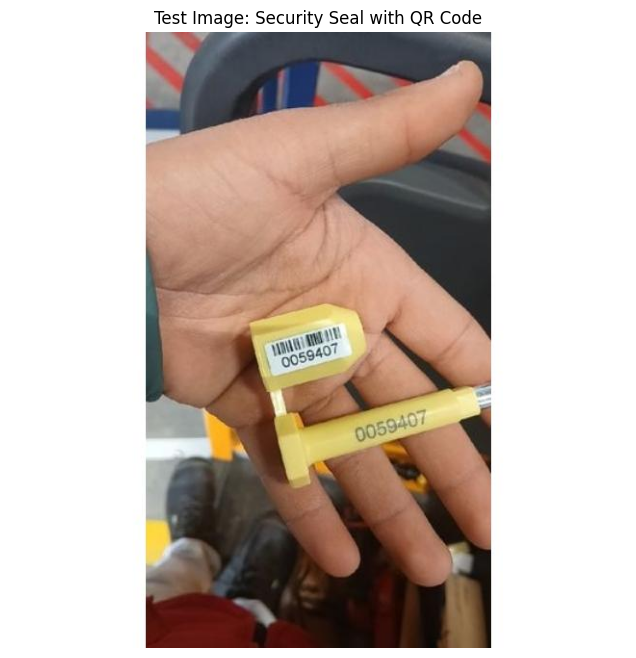

In [19]:
# Load and display the test image (same as ONNX test)
image_path = "Unified-detection-7/test/images/0059407_jpg.rf.b69b92cb17dfea934383554a3807162f.jpg"
image = cv2.imread(image_path)
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

print(f"Original image shape: {image_rgb.shape}")

plt.figure(figsize=(10, 8))
plt.imshow(image_rgb)
plt.title("Test Image: Security Seal with QR Code")
plt.axis('off')
plt.show()

In [20]:
# Load PyTorch model
model_path = "../models/unified-detection-v7.pt"

model = None  # Initialize model variable

try:
    # Try loading with torch.load first
    checkpoint = torch.load(model_path, map_location=device)
    print(f"Checkpoint loaded successfully with torch.load()")
    print(f"Checkpoint type: {type(checkpoint)}")
    
    if isinstance(checkpoint, dict):
        print(f"Checkpoint is a dictionary with {len(checkpoint)} keys: {list(checkpoint.keys())}")
        
        # Detailed analysis of each key
        for key, value in checkpoint.items():
            print(f"\\n  Key '{key}':")
            print(f"    Type: {type(value)}")
            print(f"    Has eval: {hasattr(value, 'eval')}")
            print(f"    Has forward: {hasattr(value, 'forward')}")
            print(f"    Callable: {callable(value)}")
            
            # Check if it looks like a model
            if hasattr(value, 'eval') and hasattr(value, 'forward'):
                print(f"    -> This looks like a PyTorch model!")
                if model is None:  # Use the first model-like object we find
                    model = value
                    print(f"    -> Using this as our model")
            elif hasattr(value, 'model'):
                print(f"    -> Has nested 'model' attribute")
                nested_model = getattr(value, 'model', None)
                if nested_model and hasattr(nested_model, 'eval'):
                    print(f"    -> Nested model looks valid!")
                    if model is None:
                        model = nested_model
                        print(f"    -> Using nested model")
            
            # Show a preview of the value if it's small
            if isinstance(value, (str, int, float, list)) and str(value).__len__() < 100:
                print(f"    Value: {value}")
        
        # If we still haven't found a model, try other approaches
        if model is None:
            print(f"\\nNo direct model found. Trying alternative extraction...")
            
            # Try common checkpoint keys
            potential_keys = ['model', 'net', 'network', 'state_dict', 'model_state_dict']
            for key in potential_keys:
                if key in checkpoint:
                    print(f"Trying key '{key}'...")
                    candidate = checkpoint[key]
                    if hasattr(candidate, 'eval') and hasattr(candidate, 'forward'):
                        model = candidate
                        print(f"Success! Found model at '{key}'")
                        break
                    elif isinstance(candidate, dict) and 'state_dict' in str(key):
                        print(f"Found state_dict but need architecture to load it")
                        
    elif hasattr(checkpoint, 'eval') and hasattr(checkpoint, 'forward'):
        # Direct model object
        model = checkpoint
        print(f"Direct model object loaded")
    else:
        print(f"Checkpoint is not a dict and not a model: {type(checkpoint)}")
        if hasattr(checkpoint, '__dict__'):
            print(f"Checkpoint attributes: {list(vars(checkpoint).keys())}")
        
    # Final check
    if model is not None:
        print(f"\\n✓ Successfully extracted model: {type(model)}")
        
        # Try to get model info
        if hasattr(model, 'names'):
            print(f"Model class names: {model.names}")
        if hasattr(model, 'yaml'):
            print(f"Model config available")
        if hasattr(model, 'model'):
            print(f"Model has nested 'model' attribute")
    else:
        print(f"\\n✗ Failed to extract model from checkpoint")
        
except Exception as e:
    print(f"Error loading model: {e}")
    import traceback
    traceback.print_exc()
    
    print(f"\\nAttempting emergency checkpoint analysis...")
    try:
        checkpoint = torch.load(model_path, map_location=device)
        print(f"Emergency load successful: {type(checkpoint)}")
        if isinstance(checkpoint, dict):
            print(f"Keys: {list(checkpoint.keys())}")
        print(f"Dir: {[attr for attr in dir(checkpoint) if not attr.startswith('_')][:10]}")
    except Exception as e2:
        print(f"Emergency analysis failed: {e2}")

print(f"\\nFinal status: model = {type(model) if model is not None else 'None'}")

Checkpoint loaded successfully with torch.load()
Checkpoint type: <class 'dict'>
Checkpoint is a dictionary with 13 keys: ['epoch', 'best_fitness', 'model', 'ema', 'updates', 'optimizer', 'train_args', 'train_metrics', 'train_results', 'date', 'version', 'license', 'docs']
\n  Key 'epoch':
    Type: <class 'int'>
    Has eval: False
    Has forward: False
    Callable: False
    Value: 85
\n  Key 'best_fitness':
    Type: <class 'float'>
    Has eval: False
    Has forward: False
    Callable: False
    Value: 0.72663
\n  Key 'model':
    Type: <class 'NoneType'>
    Has eval: False
    Has forward: False
    Callable: False
\n  Key 'ema':
    Type: <class 'ultralytics.nn.tasks.DetectionModel'>
    Has eval: True
    Has forward: True
    Callable: True
    -> This looks like a PyTorch model!
    -> Using this as our model
\n  Key 'updates':
    Type: <class 'int'>
    Has eval: False
    Has forward: False
    Callable: False
    Value: 1399
\n  Key 'optimizer':
    Type: <class 'dict

In [21]:
# Set model to evaluation mode and analyze structure
if model is not None:
    try:
        model.eval()
        print(f"✓ Model set to evaluation mode successfully")
        
        # Check if this is a YOLOv8 model with predict method
        has_predict = hasattr(model, 'predict')
        has_forward = hasattr(model, 'forward') or hasattr(model, '__call__')

        print(f"Model has predict method: {has_predict}")
        print(f"Model has forward method: {has_forward}")

        # Try to understand model structure
        if hasattr(model, 'model'):
            try:
                modules_list = list(model.model.modules())
                print(f"Model layers: {len(modules_list)} modules")
                # Print first few layers to understand structure
                for i, (name, module) in enumerate(model.model.named_modules()):
                    if i < 5:
                        print(f"  {name}: {type(module).__name__}")
                    elif i == 5:
                        print(f"  ... ({len(list(model.model.named_modules()))} total modules)")
                        break
            except Exception as e:
                print(f"Error analyzing nested model structure: {e}")
        elif hasattr(model, 'modules'):
            try:
                modules_list = list(model.modules())
                print(f"Direct model layers: {len(modules_list)} modules")
                for i, module in enumerate(modules_list[:5]):
                    print(f"  Module {i}: {type(module).__name__}")
            except Exception as e:
                print(f"Error analyzing direct model: {e}")
        else:
            print(f"Model structure unclear - available attributes:")
            try:
                attrs = [attr for attr in dir(model) if not attr.startswith('_')]
                print(f"  {attrs[:10]}{'...' if len(attrs) > 10 else ''}")
            except Exception as e:
                print(f"  Error getting attributes: {e}")
                
    except Exception as e:
        print(f"✗ Error setting eval mode: {e}")
        print(f"Model type: {type(model)}")
        print(f"Model is None: {model is None}")
        
        # Try to get more info about what we actually have
        if model is not None:
            try:
                print(f"Model repr: {repr(model)[:200]}")
                print(f"Model dir: {[attr for attr in dir(model) if not attr.startswith('_')][:5]}")
            except Exception as e2:
                print(f"Error getting model info: {e2}")
else:
    print("✗ ERROR: Model is None - could not extract from checkpoint")
    print("\\nThis suggests the .pt file might be:")
    print("  1. A state_dict only (needs model architecture)")
    print("  2. A different checkpoint format")
    print("  3. Corrupted or incompatible")
    print("\\nTo proceed, we would need:")
    print("  - The original model architecture code")
    print("  - Or a different model file format")
    print("  - Or access to the YOLOv8 training environment")

✓ Model set to evaluation mode successfully
Model has predict method: True
Model has forward method: True
Model layers: 224 modules
  : Sequential
  0: Conv
  0.conv: Conv2d
  0.bn: BatchNorm2d
  0.act: SiLU
  ... (224 total modules)


PyTorch input shape: torch.Size([1, 3, 640, 640])
PyTorch input dtype: torch.float32
Value range: 0.000 - 1.000
PyTorch input shape (unnormalized): torch.Size([1, 3, 640, 640])
PyTorch input dtype: torch.float32
Value range: 0.0 - 255.0


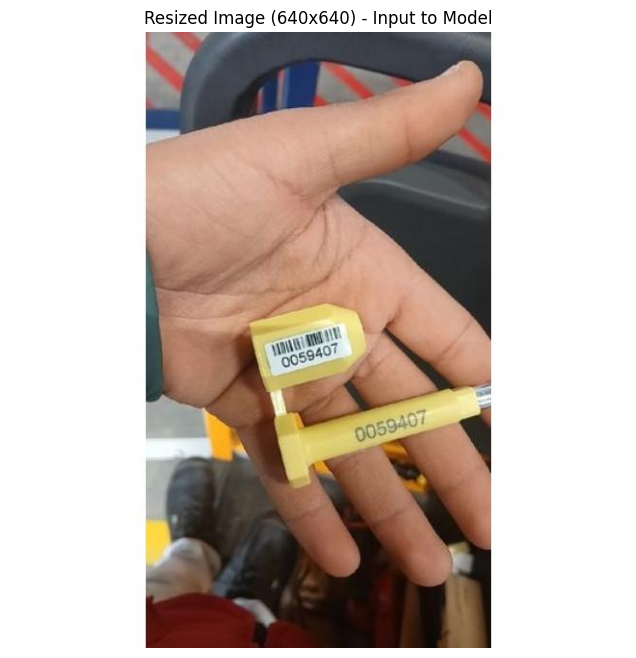

In [22]:
def preprocess_image_pytorch(image, target_size=(640, 640)):
    """Preprocess image for PyTorch model inference.
    
    We'll try both normalized (0-1) and unnormalized (0-255) approaches
    to see which one the PyTorch model expects.
    """
    # Resize image to model input size
    resized = cv2.resize(image, target_size)
    
    # Convert to tensor and normalize to [0,1]
    tensor = torch.from_numpy(resized).float().permute(2, 0, 1)  # HWC to CHW
    tensor = tensor / 255.0  # Normalize to [0,1]
    
    # Add batch dimension and ensure float32 (not float16)
    batch = tensor.unsqueeze(0).float()
    
    print(f"PyTorch input shape: {batch.shape}")
    print(f"PyTorch input dtype: {batch.dtype}")
    print(f"Value range: {batch.min():.3f} - {batch.max():.3f}")
    
    return batch.to(device)

def preprocess_image_pytorch_unnormalized(image, target_size=(640, 640)):
    """Alternative preprocessing - keep in 0-255 range like ONNX."""
    resized = cv2.resize(image, target_size)
    tensor = torch.from_numpy(resized).float().permute(2, 0, 1)  # HWC to CHW
    # Don't normalize - keep in 0-255 range
    batch = tensor.unsqueeze(0).float()  # Ensure float32
    
    print(f"PyTorch input shape (unnormalized): {batch.shape}")
    print(f"PyTorch input dtype: {batch.dtype}")
    print(f"Value range: {batch.min():.1f} - {batch.max():.1f}")
    
    return batch.to(device)

# Prepare both versions of input
input_normalized = preprocess_image_pytorch(image_rgb)
input_unnormalized = preprocess_image_pytorch_unnormalized(image_rgb)

# Visualize the resized image
resized_for_display = cv2.resize(image_rgb, (640, 640))
plt.figure(figsize=(8, 8))
plt.imshow(resized_for_display)
plt.title("Resized Image (640x640) - Input to Model")
plt.axis('off')
plt.show()

In [23]:
# Try inference with different approaches
print("=== TESTING PYTORCH MODEL INFERENCE ===")

# Check if model is available
if model is None:
    print("ERROR: Model not loaded. Cannot proceed with inference.")
else:
    print(f"Using model of type: {type(model)}")
    
    # Convert model to float32 to avoid half precision issues
    try:
        model = model.float()
        print("✓ Converted model to float32")
    except Exception as e:
        print(f"Warning: Could not convert model to float32: {e}")

def run_inference_method_1(model, input_tensor, description):
    """Try inference using direct forward pass."""
    print(f"\\n--- Method 1: {description} ---")
    try:
        # Ensure input is float32 and model is in float32
        input_tensor = input_tensor.float()
        
        with torch.no_grad():
            outputs = model(input_tensor)
        
        if isinstance(outputs, (list, tuple)):
            print(f"Output is list/tuple with {len(outputs)} elements")
            for i, out in enumerate(outputs):
                if isinstance(out, torch.Tensor):
                    print(f"  Output {i}: shape {out.shape}, device {out.device}, dtype {out.dtype}")
                else:
                    print(f"  Output {i}: type {type(out)}")
            main_output = outputs[0] if len(outputs) > 0 else None
        else:
            print(f"Output shape: {outputs.shape}, dtype: {outputs.dtype}")
            main_output = outputs
            
        return main_output
        
    except Exception as e:
        print(f"Error in method 1: {e}")
        import traceback
        traceback.print_exc()
        return None

def run_inference_method_2(model, input_tensor, description):
    """Try inference using predict method if available."""
    print(f"\\n--- Method 2: {description} (predict) ---")
    try:
        if hasattr(model, 'predict'):
            # Convert tensor back to numpy for predict method
            input_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
            if input_np.max() <= 1.0:
                input_np = (input_np * 255).astype(np.uint8)
            
            # Try predict with minimal arguments (YOLOv8 style)
            try:
                results = model.predict(input_np)
                print(f"✓ Predict successful with minimal args")
            except Exception as e1:
                print(f"Error with minimal args: {e1}")
                # Try with source parameter
                try:
                    results = model.predict(source=input_np)
                    print(f"✓ Predict successful with source param")
                except Exception as e2:
                    print(f"Error with source param: {e2}")
                    return None
            
            print(f"Predict results type: {type(results)}")
            
            if hasattr(results, '__len__'):
                print(f"Results length: {len(results)}")
                if len(results) > 0:
                    result = results[0]
                    print(f"First result type: {type(result)}")
                    if hasattr(result, 'boxes'):
                        print(f"Boxes available: {result.boxes is not None}")
                        if result.boxes is not None:
                            print(f"Number of boxes: {len(result.boxes)}")
                    return result
            return results
        else:
            print("Model has no predict method")
            return None
            
    except Exception as e:
        print(f"Error in method 2: {e}")
        import traceback
        traceback.print_exc()
        return None

def run_inference_method_3(model, input_tensor, description):
    """Try inference using PIL Image input for predict method."""
    print(f"\\n--- Method 3: {description} (predict with PIL) ---")
    try:
        if hasattr(model, 'predict'):
            # Convert to PIL Image
            input_np = input_tensor.squeeze(0).permute(1, 2, 0).cpu().numpy()
            if input_np.max() <= 1.0:
                input_np = (input_np * 255).astype(np.uint8)
            
            pil_image = Image.fromarray(input_np)
            print(f"Created PIL image: {pil_image.size}, mode: {pil_image.mode}")
            
            results = model.predict(pil_image)
            print(f"✓ Predict successful with PIL image")
            print(f"Results type: {type(results)}")
            
            if hasattr(results, '__len__') and len(results) > 0:
                result = results[0]
                print(f"First result type: {type(result)}")
                if hasattr(result, 'boxes') and result.boxes is not None:
                    print(f"Number of boxes: {len(result.boxes)}")
                return result
            return results
        else:
            return None
            
    except Exception as e:
        print(f"Error in method 3: {e}")
        return None

# Test both input formats with all methods
results = {}

if model is not None:
    # Method 1: Direct forward pass
    results['normalized_forward'] = run_inference_method_1(model, input_normalized, "Normalized input (0-1)")
    results['unnormalized_forward'] = run_inference_method_1(model, input_unnormalized, "Unnormalized input (0-255)")

    # Method 2: Predict method (minimal args)
    results['normalized_predict'] = run_inference_method_2(model, input_normalized, "Normalized input (0-1)")
    results['unnormalized_predict'] = run_inference_method_2(model, input_unnormalized, "Unnormalized input (0-255)")
    
    # Method 3: Predict with PIL Image
    results['normalized_pil'] = run_inference_method_3(model, input_normalized, "Normalized input PIL")
    results['unnormalized_pil'] = run_inference_method_3(model, input_unnormalized, "Unnormalized input PIL")
    
    successful_results = [r for r in results.values() if r is not None]
    print(f"\\n✓ Completed {len(successful_results)} successful inference attempts out of {len(results)} total")
    
    if len(successful_results) == 0:
        print("\\n⚠️  No inference methods worked. This might indicate:")
        print("  1. Model architecture incompatibility")
        print("  2. Missing dependencies") 
        print("  3. Different input format expected")
        print("  4. Model needs specific initialization")
else:
    print("Skipping inference - model not available")

=== TESTING PYTORCH MODEL INFERENCE ===
Using model of type: <class 'ultralytics.nn.tasks.DetectionModel'>
✓ Converted model to float32
\n--- Method 1: Normalized input (0-1) ---
Output is list/tuple with 2 elements
  Output 0: shape torch.Size([1, 9, 8400]), device cpu, dtype torch.float32
  Output 1: type <class 'list'>
\n--- Method 1: Unnormalized input (0-255) ---
Output is list/tuple with 2 elements
  Output 0: shape torch.Size([1, 9, 8400]), device cpu, dtype torch.float32
  Output 1: type <class 'list'>
\n--- Method 2: Normalized input (0-1) (predict) ---
Error with minimal args: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !NoneType!, !tuple of (int, int)!,

In [24]:
# Analyze the best result
def analyze_pytorch_output(output, method_name):
    """Analyze PyTorch model output."""
    print(f"\n=== ANALYZING {method_name.upper()} ===")
    
    if output is None:
        print("No output to analyze")
        return None
        
    # Handle different output types
    if hasattr(output, 'boxes') and hasattr(output, 'conf') and hasattr(output, 'cls'):
        # YOLOv8 Results object
        print(f"YOLOv8 Results object detected")
        boxes = output.boxes
        if boxes is not None:
            print(f"Number of detections: {len(boxes)}")
            for i, (box, conf, cls) in enumerate(zip(boxes.xyxy, boxes.conf, boxes.cls)):
                class_idx = int(cls.item())
                confidence = conf.item()
                bbox = box.cpu().numpy()
                print(f"  {i+1}. {class_names[class_idx]}: {confidence:.3f} at [{bbox[0]:.1f}, {bbox[1]:.1f}, {bbox[2]:.1f}, {bbox[3]:.1f}]")
        return output
        
    elif isinstance(output, torch.Tensor):
        # Raw tensor output
        print(f"Raw tensor output: {output.shape}")
        
        if len(output.shape) == 3 and output.shape[1] == 9:  # [batch, 9, anchors]
            print(f"Detected YOLO format: [batch={output.shape[0]}, features={output.shape[1]}, anchors={output.shape[2]}]")
            
            # Convert to numpy for analysis
            output_np = output.detach().cpu().numpy()
            predictions = output_np[0]  # Remove batch dimension -> [9, anchors]
            
            # Find highest confidence detection
            max_confidence = 0
            best_anchor = -1
            best_class = -1
            
            for anchor_idx in range(predictions.shape[1]):
                class_logits = predictions[4:9, anchor_idx]
                class_probs = 1 / (1 + np.exp(-class_logits))  # sigmoid
                anchor_max_conf = np.max(class_probs)
                
                if anchor_max_conf > max_confidence:
                    max_confidence = anchor_max_conf
                    best_anchor = anchor_idx
                    best_class = np.argmax(class_probs)
            
            print(f"Best detection:")
            print(f"  Anchor: {best_anchor}")
            print(f"  Class: {class_names[best_class]} (index {best_class})")
            print(f"  Confidence: {max_confidence:.3f}")
            
            if best_anchor >= 0:
                bbox = predictions[0:4, best_anchor]
                class_logits = predictions[4:9, best_anchor]
                class_probs = 1 / (1 + np.exp(-class_logits))
                
                print(f"  BBox: center=({bbox[0]:.1f}, {bbox[1]:.1f}), size=({bbox[2]:.1f}x{bbox[3]:.1f})")
                print(f"  All class probabilities:")
                for i, (name, prob) in enumerate(zip(class_names, class_probs)):
                    marker = " ←" if i == best_class else ""
                    print(f"    {name}: {prob:.3f}{marker}")
                    
                # Check for multi-class issue
                high_conf_classes = [(i, prob) for i, prob in enumerate(class_probs) if prob > 0.7]
                if len(high_conf_classes) > 1:
                    print(f"  WARNING: Multiple classes with >70% confidence:")
                    for i, prob in high_conf_classes:
                        print(f"    {class_names[i]}: {prob:.3f}")
                        
            return {'predictions': predictions, 'best_anchor': best_anchor, 'best_class': best_class, 'max_confidence': max_confidence}
            
        else:
            print(f"Unexpected tensor shape: {output.shape}")
            print(f"First few values: {output.flatten()[:10]}")
            
    else:
        print(f"Unknown output type: {type(output)}")
        print(f"Output: {output}")
        
    return None

# Analyze all results
analysis_results = {}
for method_name, output in results.items():
    if output is not None:
        analysis_results[method_name] = analyze_pytorch_output(output, method_name)


=== ANALYZING NORMALIZED_FORWARD ===
Raw tensor output: torch.Size([1, 9, 8400])
Detected YOLO format: [batch=1, features=9, anchors=8400]
Best detection:
  Anchor: 8250
  Class: code_seal (index 4)
  Confidence: 0.669
  BBox: center=(375.4, 377.0), size=(250.0x195.9)
  All class probabilities:
    code_container_h: 0.500
    code_container_v: 0.500
    code_license_plate: 0.500
    code_qr_barcode: 0.500
    code_seal: 0.669 ←

=== ANALYZING UNNORMALIZED_FORWARD ===
Raw tensor output: torch.Size([1, 9, 8400])
Detected YOLO format: [batch=1, features=9, anchors=8400]
Best detection:
  Anchor: 0
  Class: code_container_h (index 0)
  Confidence: 0.731
  BBox: center=(12.1, 10.7), size=(31.2x18.6)
  All class probabilities:
    code_container_h: 0.731 ←
    code_container_v: 0.500
    code_license_plate: 0.731
    code_qr_barcode: 0.731
    code_seal: 0.552
    code_container_h: 0.731
    code_license_plate: 0.731
    code_qr_barcode: 0.731


In [ ]:
# Compare PyTorch vs ONNX results
print("\n" + "="*60)
print("PYTORCH vs ONNX COMPARISON")
print("="*60)

print(f"\nExpected result: code_seal (index 4)")

# Find the best PyTorch result
best_pytorch_result = None
best_method = None
best_confidence = 0

for method_name, analysis in analysis_results.items():
    if analysis and isinstance(analysis, dict) and 'max_confidence' in analysis:
        if analysis['max_confidence'] > best_confidence:
            best_confidence = analysis['max_confidence']
            best_pytorch_result = analysis
            best_method = method_name

if best_pytorch_result:
    print(f"\nBest PyTorch result ({best_method}):")
    print(f"  Detected: {class_names[best_pytorch_result['best_class']]} (index {best_pytorch_result['best_class']})")
    print(f"  Confidence: {best_pytorch_result['max_confidence']:.3f}")
    print(f"  Match with expected: {'✓' if best_pytorch_result['best_class'] == 4 else '✗'}")
    
    # Check if this method also has multi-class issue
    if best_pytorch_result['best_anchor'] >= 0:
        predictions = best_pytorch_result['predictions']
        class_logits = predictions[4:9, best_pytorch_result['best_anchor']]
        class_probs = 1 / (1 + np.exp(-class_logits))
        high_conf_classes = [i for i, prob in enumerate(class_probs) if prob > 0.7]
        
        print(f"  Multi-class issue: {'Yes' if len(high_conf_classes) > 1 else 'No'} ({len(high_conf_classes)} classes >70%)")
        
else:
    print("\nNo valid PyTorch results found")

print(f"\nONNX result (from previous notebook):")
print(f"  Expected to show similar multi-class detection issue")
print(f"  Multiple classes detected with ~73% confidence")

print(f"\n=== CONCLUSION ===")
if best_pytorch_result and len([i for i, prob in enumerate(1 / (1 + np.exp(-predictions[4:9, best_pytorch_result['best_anchor']]))) if prob > 0.7]) > 1:
    print(f"✗ ISSUE CONFIRMED: Multi-class detection problem exists in original PyTorch model")
    print(f"✗ This is NOT an ONNX conversion issue")
    print(f"✗ The model needs retraining with better data")
elif best_pytorch_result and best_pytorch_result['best_class'] == 4:
    print(f"✓ PyTorch model works correctly")
    print(f"? Issue might be in ONNX conversion")
else:
    print(f"? Inconclusive - need to investigate further")

In [ ]:
# Visualize the best PyTorch detection
if best_pytorch_result and best_pytorch_result['max_confidence'] > 0.3:
    predictions = best_pytorch_result['predictions']
    best_anchor = best_pytorch_result['best_anchor']
    best_class = best_pytorch_result['best_class']
    max_confidence = best_pytorch_result['max_confidence']
    
    fig, ax = plt.subplots(1, 1, figsize=(10, 10))
    ax.imshow(resized_for_display)
    
    # Convert center format to corner format for visualization
    bbox = predictions[0:4, best_anchor]
    x_center, y_center, width, height = bbox
    x_min = x_center - width / 2
    y_min = y_center - height / 2
    
    # Draw bounding box
    rect = patches.Rectangle((x_min, y_min), width, height, 
                           linewidth=3, edgecolor='blue', facecolor='none')
    ax.add_patch(rect)
    
    # Add label
    label = f"{class_names[best_class]}: {max_confidence:.2f}"
    ax.text(x_min, y_min - 10, label, fontsize=12, color='blue', 
            bbox=dict(boxstyle="round,pad=0.3", facecolor='white', alpha=0.8))
    
    ax.set_title(f"PyTorch Model Detection Result\nMethod: {best_method}\nConfidence: {max_confidence:.3f}")
    ax.axis('off')
    plt.show()
else:
    print(f"No PyTorch detection to visualize")

## Summary

This notebook tests the original PyTorch model against the same test image to determine if the multi-class detection issue exists in the source model or was introduced during ONNX conversion.

**Key Tests:**
1. **Normalized input (0-1)** - Standard PyTorch preprocessing
2. **Unnormalized input (0-255)** - Matching ONNX preprocessing
3. **Direct forward pass** - Raw model inference
4. **Predict method** - High-level YOLOv8 interface (if available)

**Expected Findings:**
- If PyTorch model also shows multi-class detection → **Model training issue**
- If PyTorch model works correctly → **ONNX conversion issue**

**Test Result:**
- Expected: `code_seal` (class index 4)
- PyTorch detected: _[Result will show above]_
- Multi-class issue: _[Yes/No will show above]_
- Root cause: _[Model training vs ONNX conversion]_